<a href="https://colab.research.google.com/github//vlamen/tue-deeplearning/blob/main/tutorials/P5.3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 5.3: Variational Autoencoder
In this tutorial, we will implement a Variational Autoencoder (VAE) in PyTorch step by step. But first, we need to look at a bit of theory to fully define our VAE.

# Theory (part 1)
The following image from one of the papers that originally proposed the VAE (https://arxiv.org/pdf/1312.6114.pdf) shows the graphical model that a VAE represents:

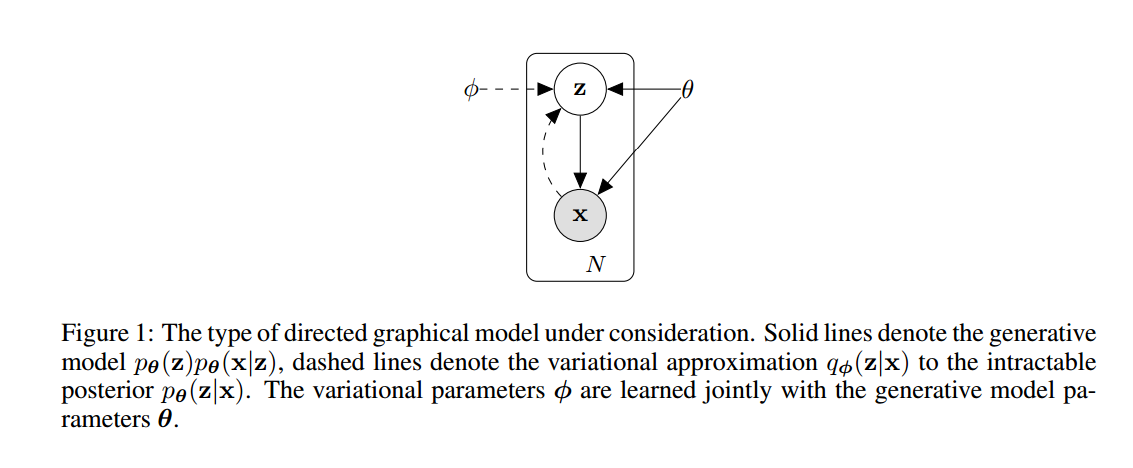

To fully define our VAE, we need to define the following distributions:
* The latent space prior $p(z)$
* The generative/conditional distribution $p(x|z)$
* The variational approximate posterior $q(z|x)$

It is common to use Gaussian (a.k.a. Normal) distributions, so we will do this too. There are other options too though!


## Latent space prior distribution $p(z)$
We will use a simple prior distribution for the latent variables; a standard factorised Gaussian (Normal) distribution:
\begin{align}
    p(\textbf{z}) &= \mathcal{N}(\textbf{z} | \textbf{0}, I) \\
    &= \prod_{k=1}^K \mathcal{N}(z_k | 0, 1) \\
    &= \prod_{k=1}^K \frac{1}{\sqrt{2\pi}} e^{-\frac{z_k^2}{2}},
\end{align}
where $\textbf{z} = (z_1, \ldots, z_K)^T$, and $K$ is the number of latent dimensions.


## Generative/conditional distribution $p(x|z)$
To create an expressive generative model, we use neural networks to parametrise $p(\textbf{x}|\textbf{z})$. Here, we use a factorised Gaussian (Normal) distribution:
\begin{align}
    p(\textbf{x}|\textbf{z}) &= \mathcal{N}(\textbf{x} | \textbf{m}, \mbox{diag}(\textbf{s}^2)) \\
    &= \prod_{d=1}^D \mathcal{N}(x_d | m_d, s_d^2) \\
    &= \prod_{d=1}^D \frac{1}{\sqrt{2\pi s_d^2}} e^{-\frac{(x_d-m_d)^2}{2s_d^2}},
\end{align}
where the mean parameter $\textbf{m} = (m_1, \ldots, m_D)^T = \textbf{m}(\textbf{z})$ is modelled with a neural network (the **decoder**) that takes latent variables $\textbf{z}$ as inputs, and $D$ is the dimensionality of the data (the number of pixels for image data). Similarly, we could learn the standard deviation parameter $\textbf{s}$ with a neural network as well, but to simplify our model we choose a fixed value $s_d = s$ that is the same for all $d=1, \ldots, D$.

*Note: we use $\textbf{m}$ and $\textbf{s}$ here for the mean and standard deviation parameters of a Gaussian, instead of the more commonly used $\mu$ and $\sigma$, so we can reserve those for the parameters of our approximate posterior (coming up next), to avoid confusion.*

## Approximate posterior distribution $q(z|x)$
For our model, we choose a factorised Gaussian, where both the means and variances are parametrised by neural networks:
\begin{align}
    q(\textbf{z}|\textbf{x}) &= \mathcal{N}(\textbf{z} | \mu, \mbox{diag}(\sigma^2)) \\
    &= \prod_{k=1}^K \mathcal{N}(z_k | \mu_k, \sigma_k^2) \\
    &= \prod_{k=1}^K \frac{1}{\sqrt{2\pi \sigma_k^2}} e^{-\frac{(z_k-\mu_k)^2}{2\sigma_k^2}},
\end{align}
where the mean parameter $\mu = (\mu_1, \ldots, \mu_K)^T = \mu(\textbf{x})$ and standard deviation parameter $\sigma = (\sigma_1, \ldots, \sigma_K)^T = \sigma(\textbf{x})$ are modelled with a neural network (the **encoder**) that takes data points $\textbf{x}$ as inputs.

## Autoencoder structure
Linking all components together, with the chosen distributions, we can see an autoencoder structure emerge:


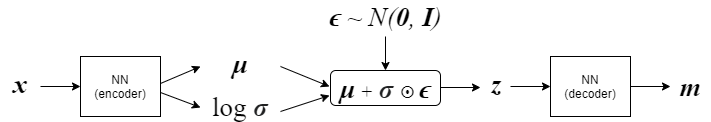

To sample a $\textbf{z}$ given $\mu$ and $\sigma$ we use the reparameterization trick, we will explain this in the next theory part. But first let's look at some code!

NOTE: we model $\log \sigma$ as opposed to $\sigma$ for numerical stability (and such that the possible values are all the real numbers, as opposed to only positive numbers).

# Implementation (part 1)
With the distributions defined, let's start implementing the VAE. We will revisit some theory later for the training procedure.

### Imports

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Data
Let's train a VAE on the MNIST dataset of handwritten digits.

In [2]:
dataset_path = '~/datasets'
batch_size = 100

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

### Encoder architecture
The encoder has two outputs, which as we've seen represent the $\mu$ and $\log \sigma$ parameters of a Gaussian distribution, the approximate posterior $q(z|x)$.

In this example, we choose a latent space dimension of 2 such that we can easily plot the latent space (note that for good results, however, higher latent dimensions are typically needed).

In this example, the architecture is a simple network with only fully connected layers. But in general, any network architecture (e.g. convolutions) can be used. The network is only split up into $\mu$ and $\log\sigma$ at the end, the first layers are shared.

NOTE: for the hidden layers we use a ReLU activation, but for $\mu$ and $\log\sigma$ we do **not** add any activations, since $\mu$ can be any real value, and $\sigma$ can be any real positive value (hence $\log\sigma$ can be any real value).

### Sampling with the reparameterization trick
We implement sampling with the reparameterization trick inside the Encoder module. Reparameterization takes the parameters of $q(z|x)$ as input, and returns a sample from $q(z|x)$. This is done by first sampling from a standard Gaussian (Normal) distribution, and then applying the proper transformation to obtain a sample from $q(z|x)$ with the given mean and variance.





In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z

### Decoder architecture
The input for the encoder is a sample of latent variables, the output represents the parameters of the generative distribution $p(x|z)$, in our case the mean of a Gaussian distribution. Again we use a simple fully connected network for this example.

Note the activation of the output layer: we use a sigmoid to guarantee pixel values between 0 and 1.

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr

## Putting it all together
Now we connect the encoder and the decoder into a single VAE. The VAE takes images `x` as input, then uses the encoder to compute the parameters `mu` and `log_sigma` (the VAE outputs these since they are needed for the loss function), as well as sampled latent variables `z` obtained with the reparameterization trick. These `z` are decoded into the mean parameters $m$ of $p(x|z)$ (as described before), which represents a reconstructed image `x_reconstr` that is also output by the VAE (and is also needed for the loss function).

In [5]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

Let's instantiate a VAE model now:

In [6]:
x_dim  = 784
hidden_dim = 500
latent_dim = 2  # NOTE: a 2-dimensional latent space allows for nice latent space plots, but is too low-dimensional to perform well in general

cuda = True  # NOTE: if running in Google Colab, make sure to go to "Edit > Notebook settings" and set "Hardware accelerator" to "GPU"
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

# Theory (part 2)
Before we setup the loss function for the model, let's revisit a bit of theory.

## Training: Evidence Lower Bound (ELBO)
As we've learned in the course, VAEs are essentially trained with maximum likelihood estimation, i.e. maximising $\log p(X)$ for the dataset $X$. But since this quantity is intractable for a VAE we instead maximise a lower bound to this, the Evidence Lower Bound (ELBO). For a single data point it looks like this:
\begin{align}
    \log p(\textbf{x}) &\geq \mathbb{E}_{q(\textbf{z}|\textbf{x})} [\log p(\textbf{x}|\textbf{z})] - KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z}))
\end{align}

Neural network training is usually formulated in terms of a loss function that needs to be **minimised**, whereas the ELBO needs to be **maximised**. So, we can simply define our loss function as the negative ELBO:
\begin{align}
    -\mathbb{E}_{q(\textbf{z}|\textbf{x})} [\log p(\textbf{x}|\textbf{z})] + KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z})).
\end{align}
We look at these two loss terms individually.

## Reconstruction loss term: $-\mathbb{E}_{q(\textbf{z}|\textbf{x})} [\log p(\textbf{x}|\textbf{z})]$
This term contains an expectation over a continuous distribution, which is an integral over a neural network. This is intractable, but can easily be approximated with single-sample Monte Carlo estimation. Or in simpler terms: just sample one value $z$ from the approximate posterior $q(z|x)$ (the encoder with data point $x$ as input), and then compute $- \log p(x|z)$ for that $z$. It's important to realise that this sampling is only possible with the *reparameterization trick* as explained in the course, since every step in the neural network needs to be differentiable to be able to train with stochastic gradient descent.

### OPTIONAL MATH ASSIGNMENT:
Write out $- \log p(\textbf{x}|\textbf{z})$ for this factorised Gaussian distribution, and simplify the expression as much as possible.
* Can you relate this expression to a commonly used loss function for neural networks? *(Hint: note that terms that are constant w.r.t. the learned parameters $\mu$ will not affect the learning, as their derivative will be zero.)*
* Do you understand why this term is usually called the reconstruction loss? 
* In particular, what happens if we choose $\sigma = \frac{1}{\sqrt{2}}$?

### SOLUTION:
\begin{align}
    - \log p(\textbf{x}|\textbf{z}) &= - \log \prod_{d=1}^D \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x_d-\mu_d)^2}{2\sigma^2}} \\
    &= -\sum_{d=1}^D \log \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x_d-\mu_d)^2}{2\sigma^2}} \\
    &= \sum_{d=1}^D \left( \frac{(x_d-\mu_d)^2}{2\sigma^2} + \frac{1}{2} \log 2\pi\sigma^2 \right)
\end{align}

Note that the second term is constant w.r.t. the learned parameter $\mu$, so it is not relevant for the gradients of the neural network. So the part that is relevant for training looks like this:
\begin{align}
\sum_{d=1}^D \frac{(x_d-\mu_d)^2}{2\sigma^2}
\end{align}

In particular, if we set $\sigma = \frac{1}{\sqrt{2}}$, it becomes:
\begin{align}
\sum_{d=1}^D (x_d-\mu_d)^2
\end{align}

This is just an element-wise squared error, similar to the common Mean Squared Error (MSE) loss function. There is one key difference though: the "mean" part of MSE would take the mean/average over all pixels $d$, whereas in this case we sum over all $d$ without dividing by the total $D$. The difference is only a scaling, but is important since we have another loss term (the KL Divergence) that needs to be appropriately weighted.

## Second term: $KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z}))$
KL divergence is essentially also an expectation, so it could be approximated with Monte Carlo sampling as well. For two Gaussians (as in our chosen model) however it is possible to compute the KL divergence analytically. It is given as follows (the derivation is left as an exercise to the reader...):
\begin{align}
    KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z})) = \frac{1}{2} \sum_{k=1}^K (\mu_k^2 + \sigma_k^2 - \log \sigma_k^2 - 1).
\end{align}
Gradients w.r.t. $\mu$ and $\sigma$ can be computed exactly for this expression, so it can directly be used in a neural network loss function.

Note that this loss term encourages $\mu$ and $\sigma$ to stay close to $\textbf{0}$ and $\textbf{1}$, respectively.

# Implementation (part 2)
## Loss function and training
Now let's implement this loss function and use it to train the VAE with an Adam optimizer.

For the reconstruction loss, we'll skip the second (constant) term and assume $\sigma = 1/\sqrt{2}$, such that we can implement it as a squared loss as explained in the theory part above. We can use `nn.functional.mse_loss()` for this, as long as we set `reduction='sum'` to avoid taking the mean over all pixels.

CHECK: confirm for yourself that the KL Divergence as implemented here indeed corresponds to the formula above (remember the rules of logarithms: $\log\sigma^2 = 2\cdot\log\sigma$ and $e^{\log\sigma} = \sigma$).

In [7]:
lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=lr)

Let's train the VAE for 50 epochs

In [8]:
epochs = 50

print("Start training VAE...")
vae.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Start training VAE...
	Epoch 1 	Average Loss:  46.9977933274207 	Reconstruction Loss: 44.564576238718175 	KL Loss: 2.433217069434005
	Epoch 2 	Average Loss:  40.269247814554205 	Reconstruction Loss: 36.40199674017242 	KL Loss: 3.86725111361139
	Epoch 3 	Average Loss:  38.614586171451116 	Reconstruction Loss: 34.31986487081333 	KL Loss: 4.294721356680078
	Epoch 4 	Average Loss:  37.53955072826456 	Reconstruction Loss: 32.964143319106064 	KL Loss: 4.5754073556635735
	Epoch 5 	Average Loss:  36.82166201889216 	Reconstruction Loss: 32.09297064524859 	KL Loss: 4.728691411854229
	Epoch 6 	Average Loss:  36.330414415464574 	Reconstruction Loss: 31.469552990335455 	KL Loss: 4.860861402712203
	Epoch 7 	Average Loss:  35.93604609163058 	Reconstruction Loss: 30.98273256534328 	KL Loss: 4.953313493171399
	Epoch 8 	Average Loss:  35.61502335842941 	Reconstruction Loss: 30.555447058574185 	KL Loss: 5.05957627285303
	Epoch 9 	Average Loss:  35.36774053761477 	Reconstruction Loss: 30.276636545120773 	

## Evaluation
To be able evaluate the model, we first encode and reconstruct the entire dataset. Although encoding technically means computing $q(\bf{z}|\bf{x})$, in practice we typically only use the $\mu$ parameter as the encoding.

In [9]:
vae.eval()

x_original_list = []
y_list = []
x_reconstr_list = []
mu_list = []
log_sigma_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_reconstr, mu, log_sigma = vae(x)
        x_original_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)
        mu_list.append(mu)
        log_sigma_list.append(log_sigma)

100%|██████████| 100/100 [00:02<00:00, 36.60it/s]


### Reconstructions
We can plot some images and their reconstructions, to see of the VAE is trained well.

In [10]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy(), cmap="Greys_r")

In [11]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 28, 28)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')

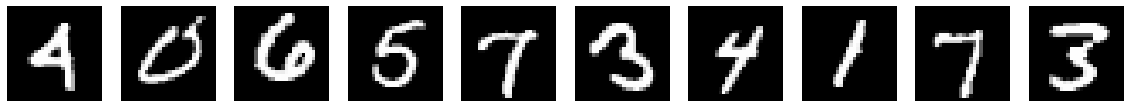

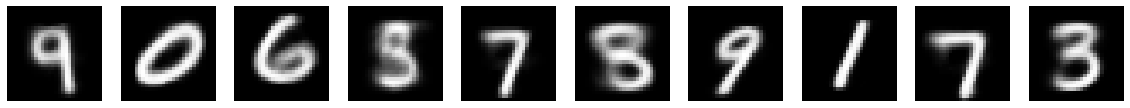

In [12]:
batch_idx = 0
show_images(x_original_list[batch_idx])
show_images(x_reconstr_list[batch_idx])

### Generating data
We can also generate new images by sampling from the prior. Note that these images are not based on any real data points, but really newly generated by the model.

In [13]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

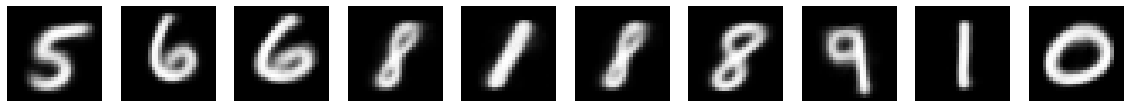

In [14]:
show_images(generated_images)

### Latent space visualizations (for 2-dimensional latent spaces only)
We can make the following plots to visualize the latent space (note that they only work for a 2-dimensional latent space).

The first plot shows the mean representations in latent space for data points from the test set. Although VAEs are unsupervised, we do have label information for the MNIST data, so we can use this give data points a different colour depending on their label.

The second plot takes linearly spaced coordinates in latent space, decodes them into data space representations (images), and plots them in a grid according to the latent space coordinates. So each of the images are generated, not reconstructed from data.

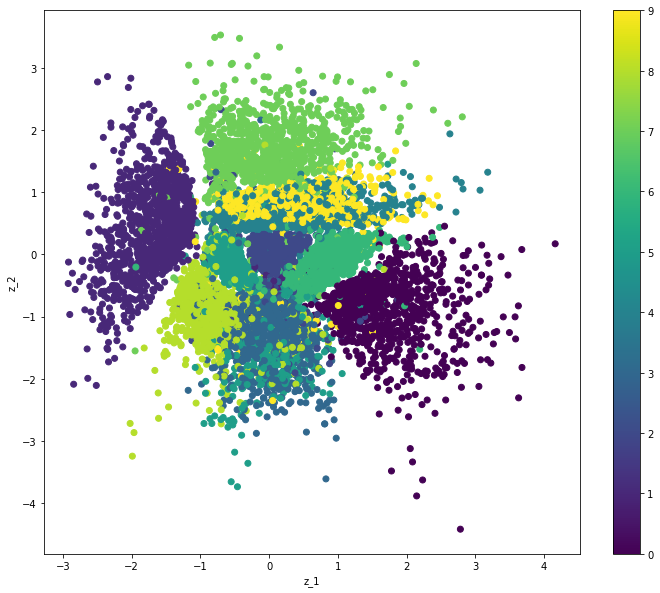

In [15]:
plt.figure(figsize=(12, 10))
for mu, y in zip(mu_list, y_list):
    mu = mu.cpu().numpy()
    plt.scatter(mu[:, 0], mu[:, 1], c=y)
plt.colorbar()
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.show()

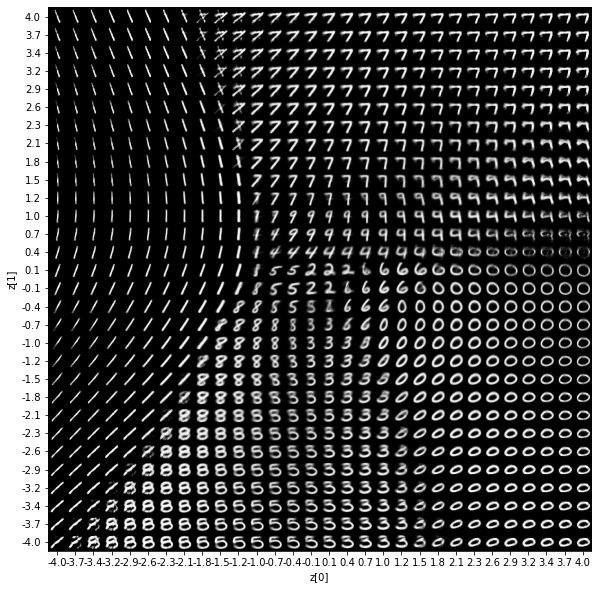

In [16]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]], dtype=np.float32)
        z_sample_torch = torch.from_numpy(z_sample).to(DEVICE)
        x_decoded_torch = decoder(z_sample_torch)
        x_decoded = x_decoded_torch.cpu().detach().numpy()
        x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()

That's it! We've successfully trained a VAE with Gaussian distributions for MNIST. Of course, we can obtain better results with better architectures for the encoder and decoder. Many ideas for discriminitive models (e.g. classification/regression networks) can be used for the encoder/decoder of a VAE as well, such as convolutions, residual connections, etc. (but typically stochastic methods like Batch Normalization or Dropout are not used in VAEs, as the sampling layer already provides stochasticity).

Note that the VAE is a generative model that can be used in a number of ways:
* Generate data by sampling from the prior first (in our case: sampling Gaussian noise), and then decoding this. Technically this gives us the mean of a Gaussian distribution over pixels. We could sample from this distribution (using the standard deviation per pixel that we set in the loss function), but typically the mean values themselves are used as they already represent an image.
* Obtain latent representations of data by encoding it. In our case this would give $\mu$ and $\log\sigma$ parameters, which we could use to sample from, but typically the $\mu$'s are used directly as the representations. Representations can be useful for a number of tasks, anything related to Representation Learning.
* Reconstruct data. This isn't a particularly useful task in and of itself, but it can give some insight into how well the VAE is trained, and how well the reconstructed data point fits the data that the VAE was trained on.
* Density estimation: the loss function used for training the VAE is a lower bound to the log likelihood of the data ($\log p(x)$). So we can use it as an estimate for the likelihood of unseen data points. Intuitively, a data example that is similar to the data the VAE was trained on should get a higher likelihood value (so a lower loss value), whereas a data example that is very different should get a lower likelihood (so higher loss value). Density estimation is useful various tasks, such as anomaly detection.